In [1]:
import numpy as np
import os
from ECG.eager_ops import expected_gradients as eg
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from sklearn.utils import resample
import wfdb as wf

In [2]:
path = "./eval_data_10k/"

In [3]:
os.listdir(path)

['cnn_ph',
 'cnn_ph_eg',
 'cnn_pl',
 'cnn_pl_eg',
 'lstm_ph',
 'lstm_ph_eg',
 'lstm_pl',
 'lstm_pl_eg',
 'resamp_trset_y.npy',
 'svc_ph',
 'svc_pl',
 'teset_x.npy',
 'teset_y.npy',
 'trset_y.npy']

In [48]:
# Creating the confusion matrices for PH
# cnn_ph_cv1 = np.load(path+ph_folders[0]+"/cms_cv1.npy")

In [30]:
def get_cmss(foldername, tname):
    if tname == "ph":
        cmss = []
        for i in range(1,11):
            cmss.append(np.load(path+foldername+"/cms_cv"+str(i)+".npy").reshape(1,8,8))
        cmss = np.concatenate(tuple(cmss), axis=0)
        return cmss
    elif tname == "pl":
        return np.load(path+foldername+"/cms.npy")

def get_results(foldername, tname):
    if tname == "ph":
        results = []
        for i in range(1,11):
            results.append(np.load(path+foldername+"/results_cv"+str(i)+".npy", allow_pickle=True)[1:6])
        return np.stack(tuple(results))
    elif tname == "pl":
        return np.load(path+foldername+"/results.npy", allow_pickle=True)[0][1:6]


In [31]:
def make_cm(cmss, name, fname):
    categories=['N','L','R','V','A','F','f','/']
    plt.figure(figsize=(10,7), dpi=300)
    sns.heatmap(cmss.mean(axis=0), annot=True, xticklabels=categories, yticklabels=categories)
    plt.title(name)
    # plt.savefig("./images/"+fname,dpi=300)
    plt.show()

### Generating Confusion Matrices

In [5]:
# a = get_cmss("cnn_ph", "ph")# done!
# b = get_cmss("lstm_ph", "ph")# done!
# c = get_cmss('cnn_ph_eg', "ph")# done!
# d = get_cmss('lstm_ph_eg', "ph")
# s = get_cmss('svc_ph', "ph")# done!
# make_cm(a, "CNN - Beat holdout Confusion Matrix", "cnn_ph")# done!
# make_cm(b, "LSTM - Beat holdout Confusion Matrix", "lstm_ph")# done!
# make_cm(c, "CNN - Beat holdout with ECG Confusion Matrix", "cnn_ph_eg")# done!
# make_cm(d, "LSTM - Beat holdout with ECG Confusion Matrix",'lstm_ph_eg')
# make_cm(s, "SVC - Beat holdout Confusion Matrix", "svc_ph")# done!

In [16]:
# e = get_cmss("cnn_pl", "pl")
# f = get_cmss("lstm_pl", "pl")
# g = get_cmss('cnn_pl_eg', "pl")
# h = get_cmss('lstm_pl_eg', "pl")
# t = get_cmss('svc_pl', "pl")
# make_cm(e, "CNN - Patient leaveout Confusion Matrix", "cnn_pl")
# make_cm(f, "LSTM - Patient leaveout Confusion Matrix", "lstm_pl")
# make_cm(g, "CNN - Patient leaveout with ECG Confusion Matrix", 'cnn_pl_eg')
# make_cm(h, "LSTM - Patient leaveout with ECG Confusion Matrix", 'lstm_pl_eg')
# make_cm(t, "SVC - Patient leaveout Confusion Matrix", "svc_pl")

In [7]:
# d_r = get_results("cnn_pl", "pl")
# e_r = get_results("lstm_pl", "pl")
# f_r = get_results('cnn_pl_eg', "pl")
# g_r = get_results('lstm_pl_eg', "pl")
# print(d_r[3][1:6])
# print(f_r[0][1:6])
# print(e_r[0][1:6])
# print(g_r[0][1:6])

In [8]:
def cal_eg(m, dx, dy): 
  test_d = tf.data.Dataset.from_tensor_slices((dx,dy))
  test_d = test_d.batch(200)
  att = None
  for i, (x_batch, y_batch) in enumerate(test_d):
    if i==0:
        att = eg(inputs=x_batch, labels=y_batch, model=m)
    else:
        att = np.append(att,eg(inputs=x_batch, labels=y_batch, model=m),axis=0)
  return att

def eg_att(foldername, tname):
    if tname=="ph":
        test_y = np.load("./eval_data_10k/teset_y.npy", allow_pickle=True)
        test_x = np.load("./eval_data_10k/teset_x.npy", allow_pickle=True)
        attributions = []
        for i in range(1,11):
            m = tf.keras.models.load_model(path+foldername+"/Model_cv"+str(i)+".h5")
            dx = test_x[i-1].reshape(-1, test_x[i-1].shape[1], 1).astype(np.float32)
            dy = tf.keras.utils.to_categorical(test_y[i-1].astype(np.float32))
            attributions.append(cal_eg(m, dx, dy))
        return attributions
    elif tname=="pl":
        test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
        test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
        test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
        test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)
        dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
        dy = tf.keras.utils.to_categorical(test_y_c01[:,0])
        m = tf.keras.models.load_model(path+foldername+"/Model0.h5")
        return cal_eg(m, dx, dy)

In [ ]:
# test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
# test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
# test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
# test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)
# dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
# dy = tf.keras.utils.to_categorical(test_y_c01[:,0])
# print(dy.shape, dx.shape)

(9902, 9) (9902, 920, 1)


In [ ]:
# m = tf.keras.models.load_model(path+"cnn_pl"+"/Model0.h5")
# cal_eg(m, dx, dy).shape

(9902, 920, 1)

In [69]:
# EG graphs
att= np.load("./eg_attributions/lstm_pl_eg.npy")
test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)
dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
dy = tf.keras.utils.to_categorical(test_y_c01[:,0])


### Function to plot attribution maps

In [6]:
def normalise_att(att):
    return (att-np.min(att))/(np.max(att)-np.min(att))

In [74]:
def get_att_maps(foldername, tname, class_l, title, att_f_name):
    categories=['N','L','R','V','A','F','PN','P']
    if tname=="ph":
        # Loading data
        test_y = np.load("./eval_data_10k/teset_y.npy", allow_pickle=True)
        test_x = np.load("./eval_data_10k/teset_x.npy", allow_pickle=True)
        atts = []
        for i in range(1,11):
            atts.append(np.array([normalise_att(i) for i in np.load("./"+att_f_name+"/"+foldername+"/att"+str(i)+".npy").squeeze()]))
        indexes_for_class = [np.where(i==class_l) for i in test_y][:4]#---
        # class atts for each cv
        atts_for_class = [atts[i][indexes_for_class[i][0]] for i in range(len(indexes_for_class))]
        # mean atts for every cv
        mean_atts_each_cv = np.array([np.mean(i, axis=0) for i in atts_for_class])
        # mean atts of all cvs
        mean_cv_atts = mean_atts_each_cv.mean(axis=0)
        # getting signals for each cv
        beats_for_class = [test_x[i][indexes_for_class[i][0]].squeeze() for i in range(len(indexes_for_class))]
        # mean beat for every cv
        mean_beats_each_cv = np.array([np.mean(i, axis=0) for i in beats_for_class])
        # mean beat of all cvs
        mean_cv_beat = mean_beats_each_cv.mean(axis=0)
        
        plt.figure(figsize=(14,4), dpi=300)
        plt.plot(mean_cv_beat)
        plt.title(title)
        plt.scatter(np.arange(len(mean_cv_beat)), mean_cv_beat, cmap='inferno_r', c=mean_cv_atts, s=50)
        clim= np.ravel(mean_cv_atts)
        plt.clim(min(clim),max(clim))
        plt.colorbar()
        plt.savefig("./images/attributions/"+foldername+"/"+categories[class_l-1],dpi=300)
        # print("./images/attributions/"+foldername+"/"+categories[class_l-1])
        plt.show()
    elif tname=="pl":
        # Loading data
        test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
        test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
        test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
        test_y_c01 = np.concatenate((test_c0[:, -2:], test_c1[:, -2:]), axis=1)
        dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
        dy = tf.keras.utils.to_categorical(test_y_c01[:,0])
        atts = np.array([normalise_att(i) for i in np.load("./"+att_f_name+"/"+foldername+".npy").squeeze()])
        # Getting the indexes for the chosen class
        indexes_for_class = np.where(test_y_c01==class_l)[0]
        # Getting the attributions
        atts_for_class = atts[indexes_for_class]
        # Getting the beats
        beats_for_class = dx[indexes_for_class].squeeze()
        # Mean attribution
        mean_atts = atts_for_class.mean(axis=0)
        # Mean beat
        mean_beat = beats_for_class.mean(axis=0)

        plt.figure(figsize=(14,4), dpi=300)
        plt.plot(mean_beat)
        plt.title(title)
        plt.scatter(np.arange(len(mean_beat)), mean_beat, cmap='inferno_r', c=mean_atts, s=50)
        clim= np.ravel(mean_atts)
        plt.clim(min(clim),max(clim))
        plt.colorbar()
        plt.savefig("./images/attributions/"+foldername+"/"+categories[class_l-1],dpi=300)
        # print("./images/attributions/"+foldername+"/"+categories[class_l-1])
        plt.show()





#### Expected gradients

In [181]:
# categories=['N','L','R','V','A','F','f','P']
# get_att_maps("cnn_ph_eg", "ph", 1, "CNN - Beat holdout Attribution Map - Normal Beat (N)")
# get_att_maps("cnn_ph_eg", "ph", 2, "CNN - Beat holdout Attribution Map - LBBB Beat (L)")
# get_att_maps("cnn_ph_eg", "ph", 3, "CNN - Beat holdout Attribution Map - RBBB Beat (R)")
# get_att_maps("cnn_ph_eg", "ph", 4, "CNN - Beat holdout Attribution Map - Premature Ventricular Contraction (V)")
# get_att_maps("cnn_ph_eg", "ph", 5, "CNN - Beat holdout Attribution Map - Atrial Premature Beat (A)")
# get_att_maps("cnn_ph_eg", "ph", 6, "CNN - Beat holdout Attribution Map - Fused Ventricular & Normal Beat (F)")
# get_att_maps("cnn_ph_eg", "ph", 7, "CNN - Beat holdout Attribution Map - Fused Paced & Normal Beat (f)")
# get_att_maps("cnn_ph_eg", "ph", 8, "CNN - Beat holdout Attribution Map - Paced Beat (/)")

In [183]:
# get_att_maps("lstm_ph_eg", "ph", 1, "LSTM - Beat holdout Attribution Map - Normal Beat (N)")
# get_att_maps("lstm_ph_eg", "ph", 2, "LSTM - Beat holdout Attribution Map - LBBB Beat (L)")
# get_att_maps("lstm_ph_eg", "ph", 3, "LSTM - Beat holdout Attribution Map - RBBB Beat (R)")
# get_att_maps("lstm_ph_eg", "ph", 4, "LSTM - Beat holdout Attribution Map - Premature Ventricular Contraction (V)")
# get_att_maps("lstm_ph_eg", "ph", 5, "LSTM - Beat holdout Attribution Map - Atrial Premature Beat (A)")
# get_att_maps("lstm_ph_eg", "ph", 6, "LSTM - Beat holdout Attribution Map - Fused Ventricular & Normal Beat (F)")
# get_att_maps("lstm_ph_eg", "ph", 7, "LSTM - Beat holdout Attribution Map - Fused Paced & Normal Beat (f)")
# get_att_maps("lstm_ph_eg", "ph", 8, "LSTM - Beat holdout Attribution Map - Paced Beat (/)")

In [78]:
# get_att_maps("cnn_pl_eg", "pl", 1, "CNN - Patient leaveout Attribution Map - Normal Beat (N)", "eg_attributions")
# get_att_maps("cnn_pl_eg", "pl", 2, "CNN - Patient leaveout Attribution Map - LBBB Beat (L)", "eg_attributions")
# get_att_maps("cnn_pl_eg", "pl", 3, "CNN - Patient leaveout Attribution Map - RBBB Beat (R)", "eg_attributions")
# get_att_maps("cnn_pl_eg", "pl", 4, "CNN - Patient leaveout Attribution Map - Premature Ventricular Contraction (V)", "eg_attributions")
# get_att_maps("cnn_pl_eg", "pl", 5, "CNN - Patient leaveout Attribution Map - Atrial Premature Beat (A)", "eg_attributions")
# get_att_maps("cnn_pl_eg", "pl", 8, "CNN - Patient leaveout Attribution Map - Paced Beat (/)", "eg_attributions")

In [79]:
# get_att_maps("lstm_pl_eg", "pl", 1, "LSTM - Patient leaveout Attribution Map - Normal Beat (N)", "eg_attributions")
# get_att_maps("lstm_pl_eg", "pl", 2, "LSTM - Patient leaveout Attribution Map - LBBB Beat (L)","eg_attributions")
# get_att_maps("lstm_pl_eg", "pl", 3, "LSTM - Patient leaveout Attribution Map - RBBB Beat (R)", "eg_attributions")
# get_att_maps("lstm_pl_eg", "pl", 4, "LSTM - Patient leaveout Attribution Map - Premature Ventricular Contraction (V)", "eg_attributions")
# get_att_maps("lstm_pl_eg", "pl", 5, "LSTM - Patient leaveout Attribution Map - Atrial Premature Beat (A)", "eg_attributions")
# get_att_maps("lstm_pl_eg", "pl", 8, "LSTM - Patient leaveout Attribution Map - Paced Beat (/)", "eg_attributions")

#### Integrated gradients

In [30]:
# get_att_maps("cnn_ph_ig", "ph", 1, "CNN - Beat holdout Attribution Map - Normal Beat (N)", "ig_attributions" )
# get_att_maps("cnn_ph_ig", "ph", 2, "CNN - Beat holdout Attribution Map - LBBB Beat (L)" , "ig_attributions")
# get_att_maps("cnn_ph_ig", "ph", 3, "CNN - Beat holdout Attribution Map - RBBB Beat (R)", "ig_attributions")
# get_att_maps("cnn_ph_ig", "ph", 4, "CNN - Beat holdout Attribution Map - Premature Ventricular Contraction (V)", "ig_attributions")
# get_att_maps("cnn_ph_ig", "ph", 5, "CNN - Beat holdout Attribution Map - Atrial Premature Beat (A)", "ig_attributions")
# get_att_maps("cnn_ph_ig", "ph", 6, "CNN - Beat holdout Attribution Map - Fused Ventricular & Normal Beat (F)", "ig_attributions")
# get_att_maps("cnn_ph_ig", "ph", 7, "CNN - Beat holdout Attribution Map - Fused Paced & Normal Beat (f)", "ig_attributions")
# get_att_maps("cnn_ph_ig", "ph", 8, "CNN - Beat holdout Attribution Map - Paced Beat (/)", "ig_attributions")

In [32]:
# get_att_maps("lstm_ph_ig", "ph", 1, "LSTM - Beat holdout Attribution Map - Normal Beat (N)", "ig_attributions" )
# get_att_maps("lstm_ph_ig", "ph", 2, "LSTM - Beat holdout Attribution Map - LBBB Beat (L)" , "ig_attributions")
# get_att_maps("lstm_ph_ig", "ph", 3, "LSTM - Beat holdout Attribution Map - RBBB Beat (R)", "ig_attributions")
# get_att_maps("lstm_ph_ig", "ph", 4, "LSTM - Beat holdout Attribution Map - Premature Ventricular Contraction (V)", "ig_attributions")
# get_att_maps("lstm_ph_ig", "ph", 5, "LSTM - Beat holdout Attribution Map - Atrial Premature Beat (A)", "ig_attributions")
# get_att_maps("lstm_ph_ig", "ph", 6, "LSTM - Beat holdout Attribution Map - Fused Ventricular & Normal Beat (F)", "ig_attributions")
# get_att_maps("lstm_ph_ig", "ph", 7, "LSTM - Beat holdout Attribution Map - Fused Paced & Normal Beat (f)", "ig_attributions")
# get_att_maps("lstm_ph_ig", "ph", 8, "LSTM - Beat holdout Attribution Map - Paced Beat (/)", "ig_attributions")

In [250]:
# get_att_maps("cnn_pl_ig", "pl", 1, "CNN - Patient leaveout Attribution Map - Normal Beat (N)", "ig_attributions")
# get_att_maps("cnn_pl_ig", "pl", 2, "CNN - Patient leaveout Attribution Map - LBBB Beat (L)", "ig_attributions")
# get_att_maps("cnn_pl_ig", "pl", 3, "CNN - Patient leaveout Attribution Map - RBBB Beat (R)", "ig_attributions")
# get_att_maps("cnn_pl_ig", "pl", 4, "CNN - Patient leaveout Attribution Map - Premature Ventricular Contraction (V)", "ig_attributions")
# get_att_maps("cnn_pl_ig", "pl", 5, "CNN - Patient leaveout Attribution Map - Atrial Premature Beat (A)", "ig_attributions")
# get_att_maps("cnn_pl_ig", "pl", 8, "CNN - Patient leaveout Attribution Map - Paced Beat (/)", "ig_attributions")

In [249]:
# get_att_maps("lstm_pl_ig", "pl", 1, "LSTM - Patient leaveout Attribution Map - Normal Beat (N)", "ig_attributions")
# get_att_maps("lstm_pl_ig", "pl", 2, "LSTM - Patient leaveout Attribution Map - LBBB Beat (L)", "ig_attributions")
# get_att_maps("lstm_pl_ig", "pl", 3, "LSTM - Patient leaveout Attribution Map - RBBB Beat (R)", "ig_attributions")
# get_att_maps("lstm_pl_ig", "pl", 4, "LSTM - Patient leaveout Attribution Map - Premature Ventricular Contraction (V)", "ig_attributions")
# get_att_maps("lstm_pl_ig", "pl", 5, "LSTM - Patient leaveout Attribution Map - Atrial Premature Beat (A)", "ig_attributions")
# get_att_maps("lstm_pl_ig", "pl", 8, "LSTM - Patient leaveout Attribution Map - Paced Beat (/)", "ig_attributions")

### PL Bargraph

In [235]:
svc_pl_r = get_results(foldername="svc_pl", tname="pl")
cnn_pl_r = get_results(foldername="cnn_pl", tname="pl")
lstm_pl_r = get_results(foldername="lstm_pl", tname="pl")
cnn_pl_eg_r = get_results(foldername="cnn_pl_eg", tname="pl")
lstm_pl_eg_r = get_results(foldername="lstm_pl_eg", tname="pl")

r = np.array([svc_pl_r, cnn_pl_r, lstm_pl_r, cnn_pl_eg_r, lstm_pl_eg_r]).T
r[3:] = (r[3]+r[4])/2
r = r[:4]
r_name = ["SVC","CNN", "LSTM", "CNN with EG", "LSTM with EG"]
rows = ["Accuracy", "Precision", "Recall", "F1-Score"]

In [7]:
# X = np.arange(len(r_name))
# fig = plt.figure(figsize=(18, 11))
# # ax = fig.add_axes([0,0,1,1])
# plt.bar(X - 0.15, r[0], color = 'tab:blue', width = 0.1)
# plt.bar(X - 0.05, r[1], color = 'tab:green', width = 0.1)
# plt.bar(X + 0.05, r[2], color = 'tab:orange', width = 0.1)
# plt.bar(X + 0.15, r[3], color = 'tab:red', width = 0.1)
# plt.legend(rows)
# plt.xticks([])

# # Add a table at the bottom of the axes
# the_tabel = plt.table(cellText=r,
#                       rowLabels=rows,
#                       cellLoc='center',
#                       # rowColours=['tab:blue', 'tab:green', 'tab:orange', 'tab:red'],
#                       colLabels=r_name,
#                       colColours=["lightgrey" for i in range(5)],
#                       loc='bottom')                   
# the_tabel.auto_set_font_size(False)
# the_tabel.set_fontsize(15)
# the_tabel.scale(1,2)
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.1)
# # plt.title("Model performaces for Patient leave-out Method", fontsize=23)
# plt.tight_layout()
# # plt.savefig("./images/pl_mp", dpi=300)
# plt.show()


### PH Bargraph

In [39]:
svc_ph_r = get_results(foldername="svc_ph", tname="ph")
cnn_ph_r = get_results(foldername="cnn_ph", tname="ph")
lstm_ph_r = get_results(foldername="lstm_ph", tname="ph")
cnn_ph_eg_r = get_results(foldername="cnn_ph_eg", tname="ph")
lstm_ph_eg_r = get_results(foldername="lstm_ph_eg", tname="ph")

r = np.array([svc_ph_r.mean(axis=0), cnn_ph_r.mean(axis=0), lstm_ph_r.mean(axis=0), cnn_ph_eg_r.mean(axis=0), lstm_ph_eg_r.mean(axis=0)]).T
r[3:] = (r[3]+r[4])/2
r = r[:4]
r = np.around(r.astype(np.float32), 3)
r_name = ["SVC","CNN", "LSTM", "CNN with EG", "LSTM with EG"]
rows = ["Accuracy", "Precision", "Recall", "F1-Score"]

In [52]:
cnn_ph_eg_r.T[3:].mean(axis=0)

array([0.8635, 0.885, 0.7995, 0.8455, 0.8640000000000001, 0.8495, 0.835,
       0.8515, 0.8425, 0.349], dtype=object)

In [54]:
acc_error = [svc_ph_r.T[0].std(),cnn_ph_r.T[0].std(), lstm_ph_r.T[0].std(), cnn_ph_eg_r.T[0].std(), lstm_ph_eg_r.T[0].std()]
pre_error = [svc_ph_r.T[1].std(),cnn_ph_r.T[1].std(), lstm_ph_r.T[1].std(), cnn_ph_eg_r.T[1].std(), lstm_ph_eg_r.T[1].std()]
rec_error = [svc_ph_r.T[2].std(),cnn_ph_r.T[2].std(), lstm_ph_r.T[2].std(), cnn_ph_eg_r.T[2].std(), lstm_ph_eg_r.T[2].std()]
f1_error = [svc_ph_r.T[3:].mean(axis=0).std(),cnn_ph_r.T[3:].mean(axis=0).std(), lstm_ph_r.T[3:].mean(axis=0).std(), cnn_ph_eg_r.T[3:].mean(axis=0).std(), lstm_ph_eg_r.T[3:].mean(axis=0).std()]

In [8]:
# X = np.arange(len(r_name))
# fig = plt.figure(figsize=(18,11), dpi=300)
# # ax = fig.add_axes([0,0,1,1])
# plt.bar(X - 0.15, r[0], yerr=acc_error , color = 'tab:blue', width = 0.1)
# plt.bar(X - 0.05, r[1], yerr=pre_error, color = 'tab:green', width = 0.1)
# plt.bar(X + 0.05, r[2], yerr=rec_error, color = 'tab:orange', width = 0.1)
# plt.bar(X + 0.15, r[3], yerr=f1_error, color = 'tab:red', width = 0.1)
# plt.legend(rows)
# plt.xticks([])

# # Add a table at the bottom of the axes
# the_tabel = plt.table(cellText=r,
#                       rowLabels=rows,
#                       cellLoc='center',
#                       # rowColours=['tab:blue', 'tab:green', 'tab:orange', 'tab:red'],
#                       colLabels=r_name,
#                       colColours=["lightgrey" for i in range(5)],
#                       loc='bottom')                   
# the_tabel.auto_set_font_size(False)
# the_tabel.set_fontsize(15)
# the_tabel.scale(1,2)
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.1)
# # plt.title("Model performaces for Beat holdout Method", fontsize=23)
# plt.tight_layout()
# # plt.savefig("./images/ph_mp", dpi=300)
# plt.show()


### Comparison between integrated and expedted gradients

In [104]:
def get_comp_maps(foldername, tname, class_l, title, att_f_name):
    categories=['N','L','R','V','A','F','PN','P']
    if tname=="ph":
        # Loading data
        test_y = np.load("./eval_data_10k/teset_y.npy", allow_pickle=True)
        test_x = np.load("./eval_data_10k/teset_x.npy", allow_pickle=True)
        atts = []
        r = 5 if foldername=="lstm_ph_ig" else 11
        for i in range(1,r):
            atts.append(np.array([normalise_att(i) for i in np.load("./"+att_f_name+"/"+foldername+"/att"+str(i)+".npy").squeeze()]))
        indexes_for_class = [np.where(i==class_l) for i in test_y][:r-1]#---
        # print(len(indexes_for_class))
        # print(len(atts))
        # class atts for each cv
        atts_for_class = [atts[i][indexes_for_class[i][0]] for i in range(len(indexes_for_class))]
        # mean atts for every cv
        mean_atts_each_cv = np.array([np.mean(i, axis=0) for i in atts_for_class])
        # mean atts of all cvs
        mean_cv_atts = mean_atts_each_cv.mean(axis=0)
        # getting signals for each cv
        beats_for_class = [test_x[i][indexes_for_class[i][0]].squeeze() for i in range(len(indexes_for_class))]
        # mean beat for every cv
        mean_beats_each_cv = np.array([np.mean(i, axis=0) for i in beats_for_class])
        # mean beat of all cvs
        mean_cv_beat = mean_beats_each_cv.mean(axis=0)
        
        return mean_cv_beat, mean_cv_atts
        # plt.figure(figsize=(14,4), dpi=300)
        # plt.plot(mean_cv_beat)
        # plt.title(title)
        # plt.scatter(np.arange(len(mean_cv_beat)), mean_cv_beat, cmap='inferno_r', c=mean_cv_atts, s=50)
        # clim= np.ravel(mean_cv_atts)
        # plt.clim(min(clim),max(clim))
        # plt.colorbar()
        # plt.savefig("./images/attributions/"+foldername+"/"+categories[class_l-1],dpi=300)
        # # print("./images/attributions/"+foldername+"/"+categories[class_l-1])
        # plt.show()
    elif tname=="pl":
        # Loading data
        test_c0 = np.genfromtxt('./Data/test_patients_fc.csv', delimiter=',')
        test_c1 = np.genfromtxt('./Data/test_patients_sc.csv', delimiter=',')
        test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
        test_y_c01 = np.concatenate((test_c0[:, -2:], test_c1[:, -2:]), axis=1)
        dx = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')
        dy = tf.keras.utils.to_categorical(test_y_c01[:,0])
        atts = np.array([normalise_att(i) for i in np.load("./"+att_f_name+"/"+foldername+".npy").squeeze()])
        # Getting the indexes for the chosen class
        indexes_for_class = np.where(test_y_c01==class_l)[0]
        # Getting the attributions
        atts_for_class = atts[indexes_for_class]
        # Getting the beats
        beats_for_class = dx[indexes_for_class].squeeze()
        # Mean attribution
        mean_atts = atts_for_class.mean(axis=0)
        # Mean beat
        mean_beat = beats_for_class.mean(axis=0)

        return mean_beat, mean_atts

        # plt.figure(figsize=(14,4), dpi=300)
        # plt.plot(mean_beat)
        # plt.title(title)
        # plt.scatter(np.arange(len(mean_beat)), mean_beat, cmap='inferno_r', c=mean_atts, s=50)
        # clim= np.ravel(mean_atts)
        # plt.clim(min(clim),max(clim))
        # plt.colorbar()
        # plt.savefig("./images/attributions/"+foldername+"/"+categories[class_l-1],dpi=300)
        # # print("./images/attributions/"+foldername+"/"+categories[class_l-1])
        # plt.show()





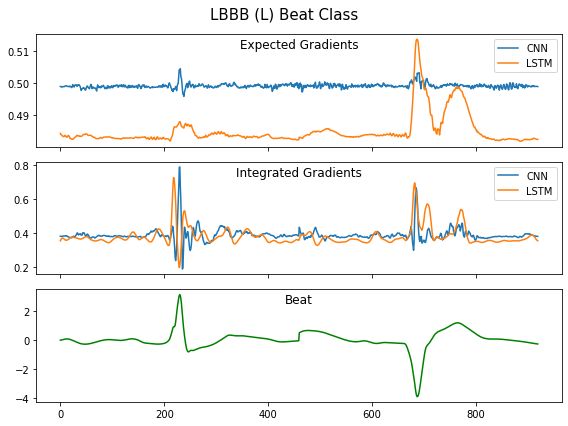

In [138]:
b,n_ig_cnn_ph = get_comp_maps("cnn_ph_ig", "ph", 2, "", "ig_attributions")
b1,n_ig_lstm_ph = get_comp_maps("lstm_ph_ig", "ph", 2, "", "ig_attributions")
be,n_eg_cnn_ph = get_comp_maps("cnn_ph_eg", "ph", 2, "", "eg_attributions")
b1e,n_eg_lstm_ph = get_comp_maps("lstm_ph_eg", "ph", 2, "", "eg_attributions")

fig, ax = plt.subplots(3, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(n_eg_cnn_ph, label="CNN")
ax[0].plot(n_eg_lstm_ph, label="LSTM")
ax[0].legend()
ax[0].set_title("Expected Gradients", y=1.0, pad=-14)
ax[1].plot(n_ig_cnn_ph, label="CNN")
ax[1].plot(n_ig_lstm_ph, label="LSTM")
ax[1].set_title("Integrated Gradients", y=1.0, pad=-14)
ax[1].legend()
ax[2].plot(b, c="g")
ax[2].set_title("Beat", y=1.0, pad=-14)
fig.suptitle("LBBB (L) Beat Class", fontsize=15)
fig.tight_layout()
plt.savefig("./images/L_ph_igeg",dpi=300)



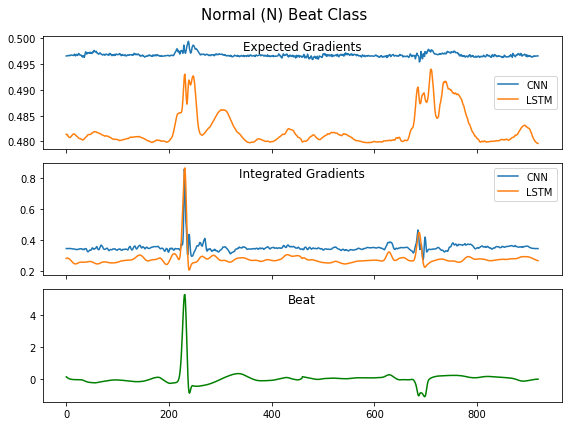

In [139]:
b,n_ig_cnn_ph = get_comp_maps("cnn_ph_ig", "ph", 1, "", "ig_attributions")
b1,n_ig_lstm_ph = get_comp_maps("lstm_ph_ig", "ph", 1, "", "ig_attributions")
be,n_eg_cnn_ph = get_comp_maps("cnn_ph_eg", "ph", 1, "", "eg_attributions")
b1e,n_eg_lstm_ph = get_comp_maps("lstm_ph_eg", "ph", 1, "", "eg_attributions")

fig, ax = plt.subplots(3, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(n_eg_cnn_ph, label="CNN")
ax[0].plot(n_eg_lstm_ph, label="LSTM")
ax[0].legend()
ax[0].set_title("Expected Gradients", y=1.0, pad=-14)
ax[1].plot(n_ig_cnn_ph, label="CNN")
ax[1].plot(n_ig_lstm_ph, label="LSTM")
ax[1].set_title("Integrated Gradients", y=1.0, pad=-14)
ax[1].legend()
ax[2].plot(b, c="g")
ax[2].set_title("Beat", y=1.0, pad=-14)
fig.suptitle("Normal (N) Beat Class", fontsize=15)
fig.tight_layout()
plt.savefig("./images/N_ph_igeg", dpi=300)



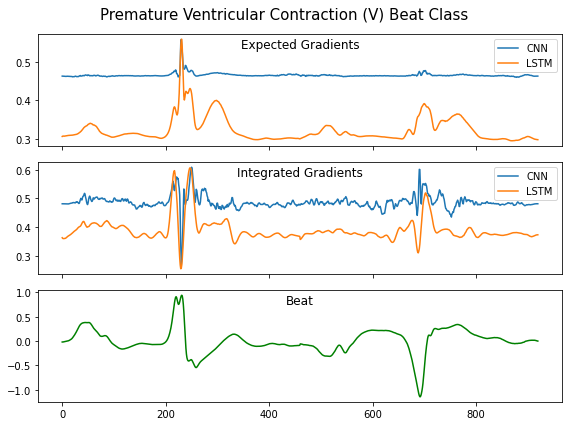

In [140]:
b,n_ig_cnn_ph = get_comp_maps("cnn_ph_ig", "ph", 4, "", "ig_attributions")
b1,n_ig_lstm_ph = get_comp_maps("lstm_ph_ig", "ph", 4, "", "ig_attributions")
be,n_eg_cnn_ph = get_comp_maps("cnn_ph_eg", "ph", 4, "", "eg_attributions")
b1e,n_eg_lstm_ph = get_comp_maps("lstm_ph_eg", "ph", 4, "", "eg_attributions")

fig, ax = plt.subplots(3, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(n_eg_cnn_ph, label="CNN")
ax[0].plot(n_eg_lstm_ph, label="LSTM")
ax[0].legend()
ax[0].set_title("Expected Gradients", y=1.0, pad=-14)
ax[1].plot(n_ig_cnn_ph, label="CNN")
ax[1].plot(n_ig_lstm_ph, label="LSTM")
ax[1].set_title("Integrated Gradients", y=1.0, pad=-14)
ax[1].legend()
ax[2].plot(b, c="g")
ax[2].set_title("Beat", y=1.0, pad=-14)
fig.suptitle("Premature Ventricular Contraction (V) Beat Class", fontsize=15)
fig.tight_layout()
plt.savefig("./images/V_ph_igeg", dpi=300)



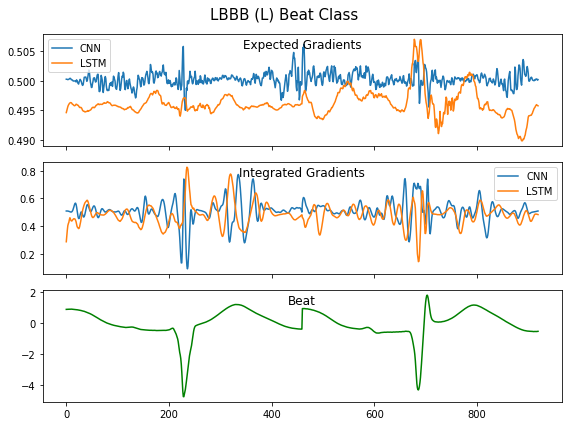

In [141]:
b,n_ig_cnn_pl = get_comp_maps("cnn_pl_ig", "pl", 2, "", "ig_attributions")
b1,n_ig_lstm_pl = get_comp_maps("lstm_pl_ig", "pl", 2, "", "ig_attributions")
be,n_eg_cnn_pl = get_comp_maps("cnn_pl_eg", "pl", 2, "", "eg_attributions")
b1e,n_eg_lstm_pl = get_comp_maps("lstm_pl_eg", "pl", 2, "", "eg_attributions")

fig, ax = plt.subplots(3, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(n_eg_cnn_pl, label="CNN")
ax[0].plot(n_eg_lstm_pl, label="LSTM")
ax[0].legend()
ax[0].set_title("Expected Gradients", y=1.0, pad=-14)
ax[1].plot(n_ig_cnn_pl, label="CNN")
ax[1].plot(n_ig_lstm_pl, label="LSTM")
ax[1].set_title("Integrated Gradients", y=1.0, pad=-14)
ax[1].legend()
ax[2].plot(b, c="g")
ax[2].set_title("Beat", y=1.0, pad=-14)
fig.suptitle("LBBB (L) Beat Class", fontsize=15)
fig.tight_layout()
plt.savefig("./images/L_pl_igeg", dpi=300)



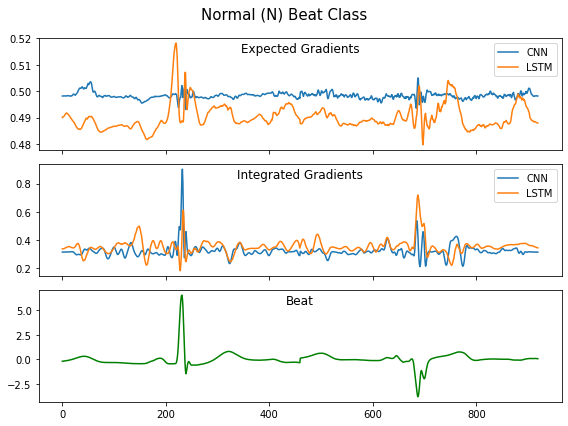

In [142]:
b,n_ig_cnn_pl = get_comp_maps("cnn_pl_ig", "pl", 1, "", "ig_attributions")
b1,n_ig_lstm_pl = get_comp_maps("lstm_pl_ig", "pl", 1, "", "ig_attributions")
be,n_eg_cnn_pl = get_comp_maps("cnn_pl_eg", "pl", 1, "", "eg_attributions")
b1e,n_eg_lstm_pl = get_comp_maps("lstm_pl_eg", "pl", 1, "", "eg_attributions")

fig, ax = plt.subplots(3, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(n_eg_cnn_pl, label="CNN")
ax[0].plot(n_eg_lstm_pl, label="LSTM")
ax[0].legend()
ax[0].set_title("Expected Gradients", y=1.0, pad=-14)
ax[1].plot(n_ig_cnn_pl, label="CNN")
ax[1].plot(n_ig_lstm_pl, label="LSTM")
ax[1].set_title("Integrated Gradients", y=1.0, pad=-14)
ax[1].legend()
ax[2].plot(b, c="g")
ax[2].set_title("Beat", y=1.0, pad=-14)
fig.suptitle("Normal (N) Beat Class", fontsize=15)
fig.tight_layout()
plt.savefig("./images/N_pl_igeg", dpi=300)


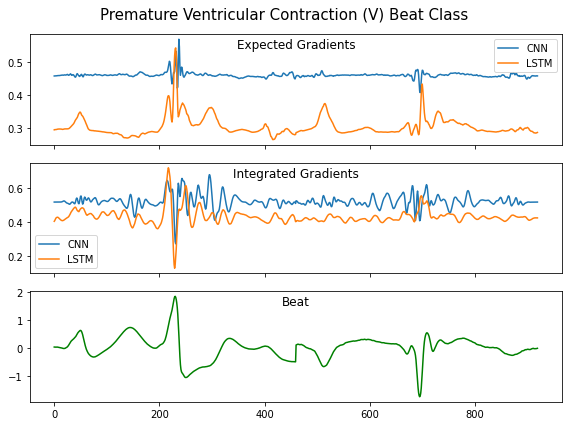

In [143]:
b,n_ig_cnn_pl = get_comp_maps("cnn_pl_ig", "pl", 4, "", "ig_attributions")
b1,n_ig_lstm_pl = get_comp_maps("lstm_pl_ig", "pl", 4, "", "ig_attributions")
be,n_eg_cnn_pl = get_comp_maps("cnn_pl_eg", "pl", 4, "", "eg_attributions")
b1e,n_eg_lstm_pl = get_comp_maps("lstm_pl_eg", "pl", 4, "", "eg_attributions")

fig, ax = plt.subplots(3, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(n_eg_cnn_pl, label="CNN")
ax[0].plot(n_eg_lstm_pl, label="LSTM")
ax[0].legend()
ax[0].set_title("Expected Gradients", y=1.0, pad=-14)
ax[1].plot(n_ig_cnn_pl, label="CNN")
ax[1].plot(n_ig_lstm_pl, label="LSTM")
ax[1].set_title("Integrated Gradients", y=1.0, pad=-14)
ax[1].legend()
ax[2].plot(b, c="g")
ax[2].set_title("Beat", y=1.0, pad=-14)
fig.suptitle("Premature Ventricular Contraction (V) Beat Class", fontsize=15)
fig.tight_layout()
plt.savefig("./images/V_pl_igeg", dpi=300)


### Dataset distribution graphs

In [14]:
test_y = np.load("./eval_data_10k/teset_y.npy", allow_pickle=True)
train_y = np.load("./eval_data_10k/trset_y.npy", allow_pickle=True)
test_x = np.load("./eval_data_10k/teset_x.npy", allow_pickle=True)

In [5]:
from collections import Counter
counters_test = Counter(test_y[0])
counters_train = Counter(train_y[0])

In [7]:
labels = ['N','L','R','V','A','F','f','/']


In [18]:
train_count = list(counters_train.values())
test_count = list(counters_test.values())

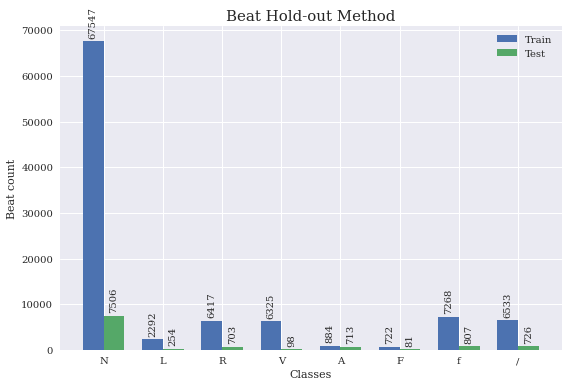

In [23]:
x = np.arange(1,len(labels)+1)  # the label locations
width = 0.35  # the width of the bars
plt.style.use('seaborn')
plt.rcParams.update({'font.family':'serif'})
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_count, width, label='Train')
rects2 = ax.bar(x + width/2, test_count, width, label='Test')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Beat count', fontsize=11)
ax.set_xlabel('Classes', fontsize=11)
ax.set_title('Beat Hold-out Method', fontsize=15)
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, rotation=90, fontsize=10)
ax.bar_label(rects2, padding=3, rotation=90, fontsize=10)

fig.tight_layout()
# plt.savefig("./images/phom.png", dpi=300)
plt.show()

In [24]:
print("starting loading")
channel_1_data = np.empty(shape=[0, 462])

c1_data = glob.glob('./Data/normal_ex_method_0.csv')

for j in c1_data:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    channel_1_data = np.append(channel_1_data, csvrows, axis=0)

print(channel_1_data.shape)

channel_2_data = np.empty(shape=[0, 462])

c2_data = glob.glob('./Data/normal_ex_method_1.csv')

for j in c2_data:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    channel_2_data = np.append(channel_2_data, csvrows, axis=0)

print(channel_2_data.shape)

starting loading
Loading  ./Data/normal_ex_method_0.csv
(108876, 462)
Loading  ./Data/normal_ex_method_1.csv
(108876, 462)


In [25]:
patient_number = [116,106,107, 207, 231]

indexes = np.array([], dtype=np.int64)

for p in patient_number:
    indexes = np.append(indexes,np.where(channel_1_data[:,-1]==p)[0], axis=0)
    # Seperating the train and testing data
test_patients = channel_1_data[indexes]
train_patients = np.delete(channel_1_data, indexes, axis=0)

print(train_patients.shape)
print(test_patients.shape)

(98974, 462)
(9902, 462)


In [26]:
train_df = pd.DataFrame(train_patients)
test_df = pd.DataFrame(test_patients)
labels = ['N','L','R','V','A','F','f','/']

train_count = train_df[460].value_counts().sort_index()
test_count = test_df[460].value_counts()
test_count[6.0] = 0
test_count[7.0] = 0
test_count = test_count.sort_index()

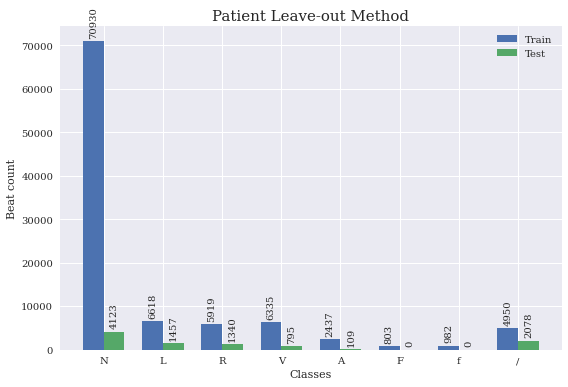

In [31]:
x = np.arange(1,len(labels)+1)  # the label locations
width = 0.35  # the width of the bars
plt.style.use('seaborn')
plt.rcParams.update({'font.family':'serif'})
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_count, width, label='Train')
rects2 = ax.bar(x + width/2, test_count, width, label='Test')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Beat count', fontsize=11)
ax.set_xlabel('Classes', fontsize=11)
ax.set_title('Patient Leave-out Method', fontsize=15)
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, rotation=90, fontsize=10)
ax.bar_label(rects2, padding=3, rotation=90, fontsize=10)

fig.tight_layout()
# plt.savefig("./images/pres_plom.png", dpi=400)
plt.show()

###### Distribution post resampling

In [33]:
train_y_r = np.load("./eval_data_10k/resamp_trset_y.npy", allow_pickle=True)

In [34]:
counters_test = Counter(test_y[0])
counters_train_r = Counter(train_y_r[0])
train_count = list(counters_train_r.values())
test_count = list(counters_test.values())

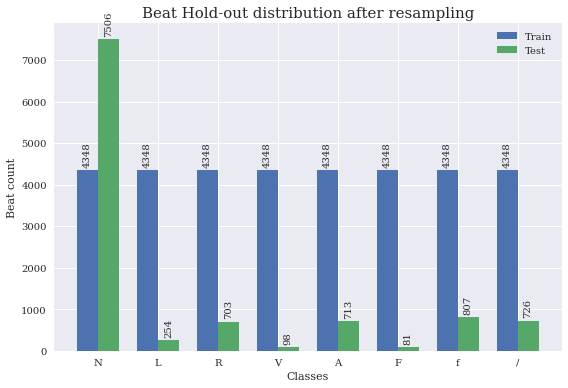

In [35]:
x = np.arange(1,len(labels)+1)  # the label locations
width = 0.35  # the width of the bars
plt.style.use('seaborn')
plt.rcParams.update({'font.family':'serif'})
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_count, width, label='Train')
rects2 = ax.bar(x + width/2, test_count, width, label='Test')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Beat count', fontsize=11)
ax.set_xlabel('Classes', fontsize=11)
ax.set_title('Beat Hold-out distribution after resampling', fontsize=15)
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, rotation=90, fontsize=10)
ax.bar_label(rects2, padding=3, rotation=90, fontsize=10)

fig.tight_layout()
# plt.savefig("./images/pres_phom_r.png", dpi=300)
plt.show()

In [40]:
pl_train = np.loadtxt("./Data/train_patients_fc.csv", delimiter=",")
pl_test = np.loadtxt("./Data/test_patients_fc.csv", delimiter=",")

In [41]:
train_df = pd.DataFrame(pl_train)
test_df = pd.DataFrame(pl_test)
labels = ['N','L','R','V','A','F','f','/']

train_count = train_df[460].value_counts().sort_index()
test_count = test_df[460].value_counts()
test_count[6.0] = 0
test_count[7.0] = 0
test_count = test_count.sort_index()

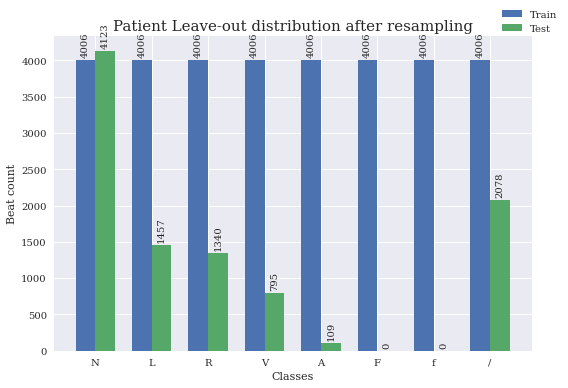

In [52]:
x = np.arange(1,len(labels)+1)  # the label locations
width = 0.35  # the width of the bars
plt.style.use('seaborn')
plt.rcParams.update({'font.family':'serif'})
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_count, width, label='Train')
rects2 = ax.bar(x + width/2, test_count, width, label='Test')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Beat count', fontsize=11)
ax.set_xlabel('Classes', fontsize=11)
ax.set_title('Patient Leave-out distribution after resampling', fontsize=15)
ax.set_xticks(x, labels)
ax.legend(borderaxespad=-3)

ax.bar_label(rects1, padding=3, rotation=90, fontsize=10)
ax.bar_label(rects2, padding=3, rotation=90, fontsize=10)

fig.tight_layout()
plt.savefig("./images/pres_plom_r.png", dpi=400)
plt.show()

### Dataset creation diagrams

In [12]:
record = wf.rdrecord("./mitbih/100")
annotation = wf.rdann("./mitbih/100", 'atr')
data = record.p_signal

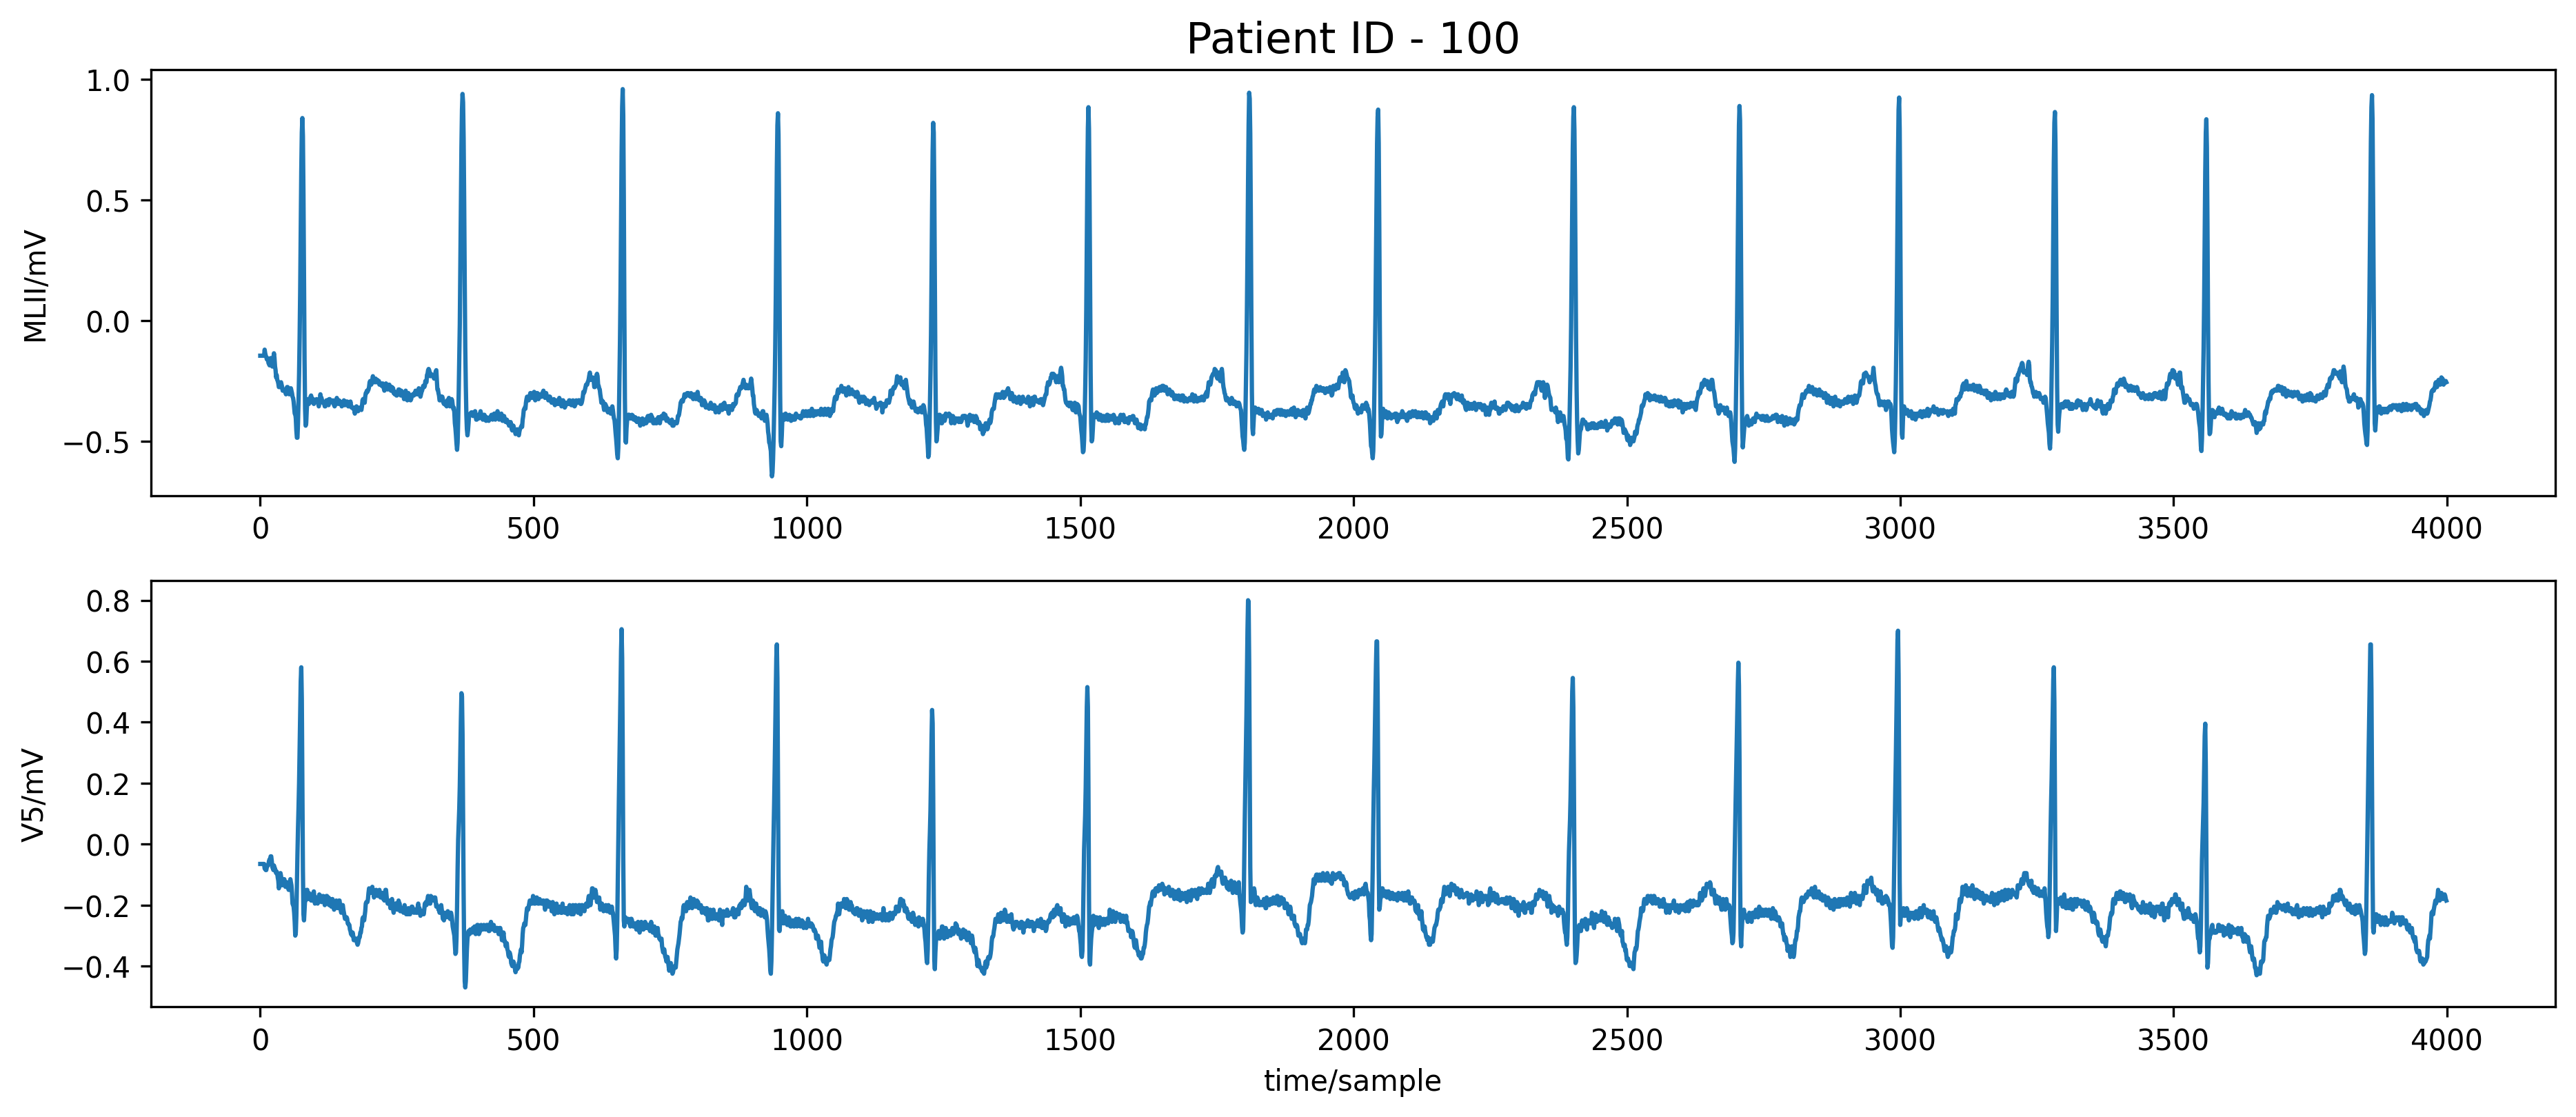

In [24]:
fig, ax = plt.subplots(2, 1, figsize = (15, 6), dpi=300)
ax[0].plot(data[0:4000,0])
ax[0].set_ylabel('MLII/mV')
ax[1].plot(data[0:4000, 1])
ax[1].set_ylabel('V5/mV')
ax[1].set_xlabel('time/sample')
ax[0].set_title('Patient ID - 100', fontsize=15)
# plt.savefig("./images/dsc_4k", dpi=300)
plt.show()

### Generating train/val accuracy and loss plots

In [4]:
def get_history(foldername, tname):
    if tname == "ph":
        results = []
        for i in range(1,11):
            results.append(np.load(path+foldername+"/history_cv"+str(i)+".npy", allow_pickle=True))
        return np.stack(tuple(results))

In [5]:
his_cnn_ph = get_history("cnn_ph", "ph")
his_lstm_ph = get_history("lstm_ph", "ph")
his_cnn_ph_eg = get_history("cnn_ph_eg", "ph")
his_lstm_ph_eg = get_history("lstm_ph_eg", "ph")

In [6]:
his_c = his_cnn_ph.mean(axis=0)
his_l = his_cnn_ph.mean(axis=0)
his_ce = his_cnn_ph_eg.mean(axis=0)
his_le = his_lstm_ph_eg.mean(axis=0)

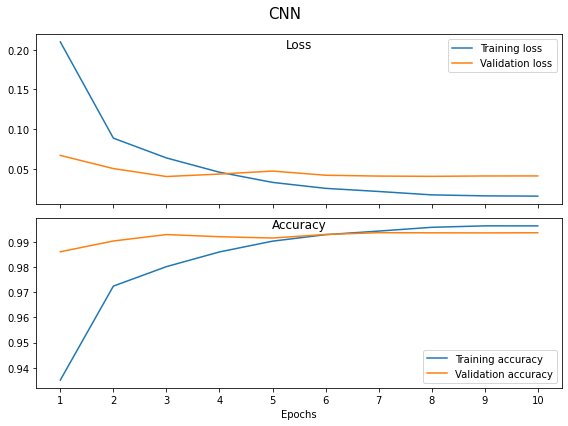

In [21]:
fig, ax = plt.subplots(2, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(his_c[0], label="Training loss")
ax[0].plot(his_c[1], label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss", y=1.0, pad=-14)
ax[1].plot(his_c[2], label="Training accuracy")
ax[1].plot(his_c[3], label="Validation accuracy")
ax[1].set_xticks(np.arange(10), np.arange(1,11))
ax[1].set_title("Accuracy", y=1.0, pad=-10)
ax[1].set_xlabel("Epochs")
ax[1].legend()
fig.suptitle("CNN", fontsize=15)
fig.tight_layout()
# plt.savefig("./images/cnn_his", dpi=300)

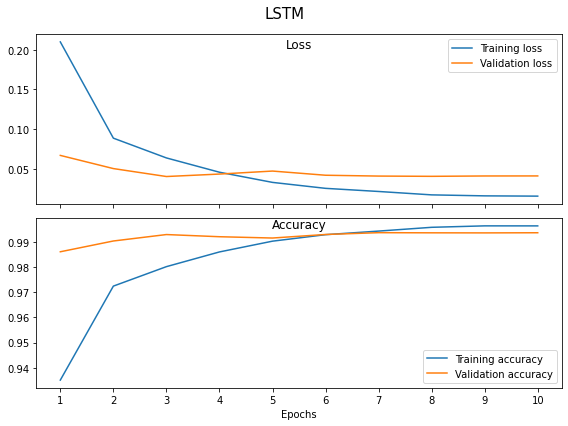

In [22]:
fig, ax = plt.subplots(2, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(his_l[0], label="Training loss")
ax[0].plot(his_l[1], label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss", y=1.0, pad=-14)
ax[1].plot(his_l[2], label="Training accuracy")
ax[1].plot(his_l[3], label="Validation accuracy")
ax[1].set_xticks(np.arange(10), np.arange(1,11))
ax[1].set_title("Accuracy", y=1.0, pad=-10)
ax[1].set_xlabel("Epochs")
ax[1].legend()
fig.suptitle("LSTM", fontsize=15)
fig.tight_layout()
# plt.savefig("./images/lstm_his", dpi=300)

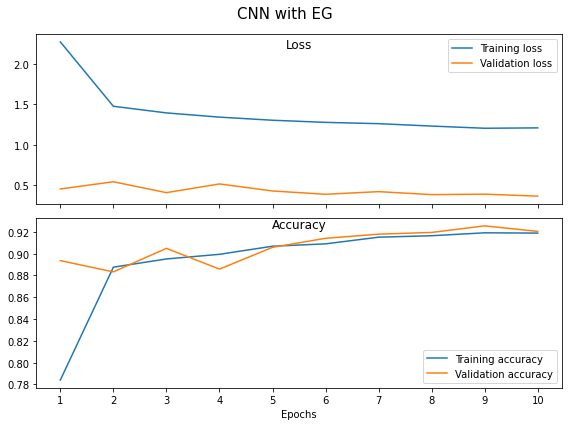

In [23]:
fig, ax = plt.subplots(2, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(his_ce[0], label="Training loss")
ax[0].plot(his_ce[1], label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss", y=1.0, pad=-14)
ax[1].plot(his_ce[2], label="Training accuracy")
ax[1].plot(his_ce[3], label="Validation accuracy")
ax[1].set_xticks(np.arange(10), np.arange(1,11))
ax[1].set_title("Accuracy", y=1.0, pad=-10)
ax[1].set_xlabel("Epochs")
ax[1].legend()
fig.suptitle("CNN with EG", fontsize=15)
fig.tight_layout()
# plt.savefig("./images/cnn_eg_his", dpi=300)

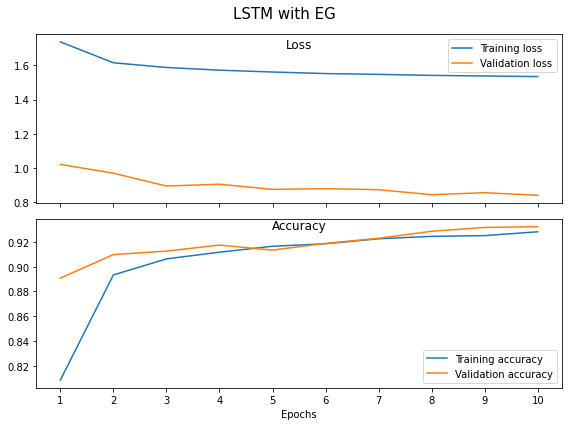

In [24]:
fig, ax = plt.subplots(2, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(his_le[0], label="Training loss")
ax[0].plot(his_le[1], label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss", y=1.0, pad=-14)
ax[1].plot(his_le[2], label="Training accuracy")
ax[1].plot(his_le[3], label="Validation accuracy")
ax[1].set_xticks(np.arange(10), np.arange(1,11))
ax[1].set_title("Accuracy", y=1.0, pad=-10)
ax[1].set_xlabel("Epochs")
ax[1].legend()
fig.suptitle("LSTM with EG", fontsize=15)
fig.tight_layout()
# plt.savefig("./images/lstm_eg_his", dpi=300)

###### Patient leaveout method

In [25]:
his_cnn_pl_eg = np.load("./eval_data_10k/cnn_pl_eg/history.npy")[:,0]
his_lstm_pl_eg = np.load("./eval_data_10k/lstm_pl_eg/history.npy")[:,0]
his_cnn_pl = np.load("./eval_data_10k/cnn_pl/history.npy")[:,0]
his_lstm_pl = np.load("./eval_data_10k/lstm_pl/history.npy")[:,0]

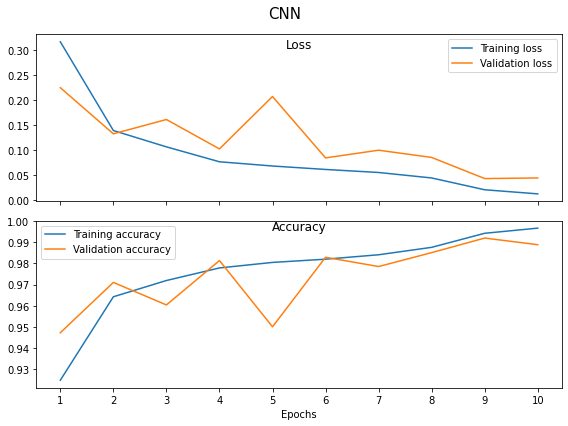

In [26]:
fig, ax = plt.subplots(2, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(his_cnn_pl[0], label="Training loss")
ax[0].plot(his_cnn_pl[1], label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss", y=1.0, pad=-14)
ax[1].plot(his_cnn_pl[2], label="Training accuracy")
ax[1].plot(his_cnn_pl[3], label="Validation accuracy")
ax[1].set_xticks(np.arange(10), np.arange(1,11))
ax[1].set_title("Accuracy", y=1.0, pad=-10)
ax[1].set_xlabel("Epochs")
ax[1].legend()
fig.suptitle("CNN", fontsize=15)
fig.tight_layout()
# plt.savefig("./images/pl_cnn_his", dpi=300)

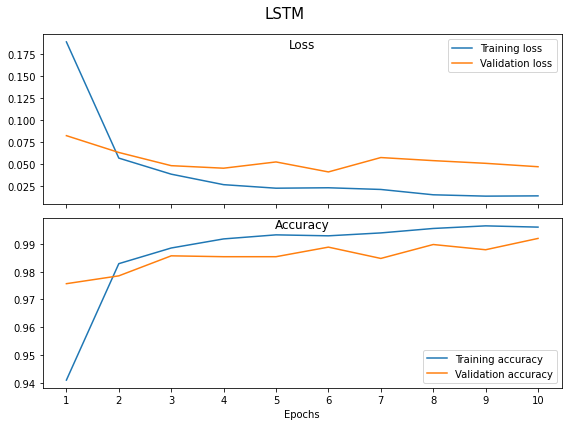

In [27]:
fig, ax = plt.subplots(2, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(his_lstm_pl[0], label="Training loss")
ax[0].plot(his_lstm_pl[1], label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss", y=1.0, pad=-14)
ax[1].plot(his_lstm_pl[2], label="Training accuracy")
ax[1].plot(his_lstm_pl[3], label="Validation accuracy")
ax[1].set_xticks(np.arange(10), np.arange(1,11))
ax[1].set_title("Accuracy", y=1.0, pad=-10)
ax[1].set_xlabel("Epochs")
ax[1].legend()
fig.suptitle("LSTM", fontsize=15)
fig.tight_layout()
# plt.savefig("./images/pl_lstm_his", dpi=300)

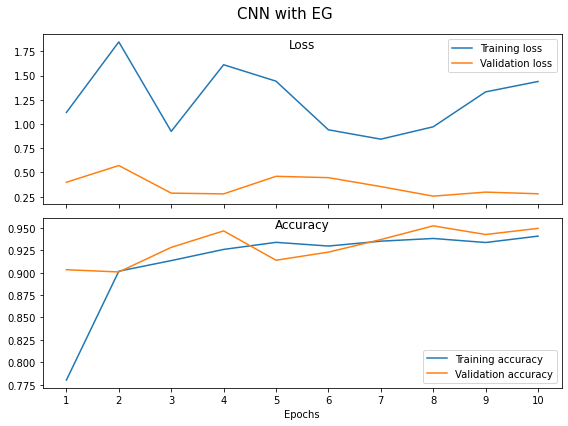

In [28]:
fig, ax = plt.subplots(2, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(his_cnn_pl_eg[0], label="Training loss")
ax[0].plot(his_cnn_pl_eg[1], label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss", y=1.0, pad=-14)
ax[1].plot(his_cnn_pl_eg[2], label="Training accuracy")
ax[1].plot(his_cnn_pl_eg[3], label="Validation accuracy")
ax[1].set_xticks(np.arange(10), np.arange(1,11))
ax[1].set_title("Accuracy", y=1.0, pad=-10)
ax[1].set_xlabel("Epochs")
ax[1].legend()
fig.suptitle("CNN with EG", fontsize=15)
fig.tight_layout()
# plt.savefig("./images/pl_cnn_eg_his", dpi=300)

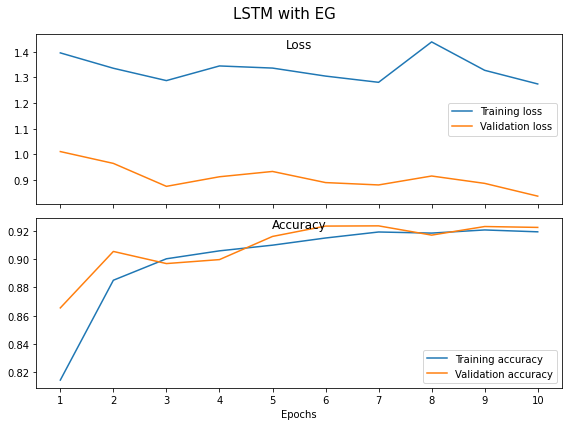

In [29]:
fig, ax = plt.subplots(2, 1,figsize=(8,6), sharex=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(his_lstm_pl_eg[0], label="Training loss")
ax[0].plot(his_lstm_pl_eg[1], label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss", y=1.0, pad=-14)
ax[1].plot(his_lstm_pl_eg[2], label="Training accuracy")
ax[1].plot(his_lstm_pl_eg[3], label="Validation accuracy")
ax[1].set_xticks(np.arange(10), np.arange(1,11))
ax[1].set_title("Accuracy", y=1.0, pad=-10)
ax[1].set_xlabel("Epochs")
ax[1].legend()
fig.suptitle("LSTM with EG", fontsize=15)
fig.tight_layout()
# plt.savefig("./images/pl_lstm_eg_his", dpi=300)

### Creating bar graphs for F1 micro and macro

In [32]:
svc_pl_r = get_results(foldername="svc_pl", tname="pl")
cnn_pl_r = get_results(foldername="cnn_pl", tname="pl")
lstm_pl_r = get_results(foldername="lstm_pl", tname="pl")
cnn_pl_eg_r = get_results(foldername="cnn_pl_eg", tname="pl")
lstm_pl_eg_r = get_results(foldername="lstm_pl_eg", tname="pl")

r = np.array([svc_pl_r, cnn_pl_r, lstm_pl_r, cnn_pl_eg_r, lstm_pl_eg_r]).T
# r[3:] = (r[3]+r[4])/2
r = r[-2:]
r_name = ["SVC","CNN", "LSTM", "CNN with EG", "LSTM with EG"]
rows = ["F1-micro", "F1-macro"]

In [72]:
# X = np.array([0,1,2,3,4], dtype='float')

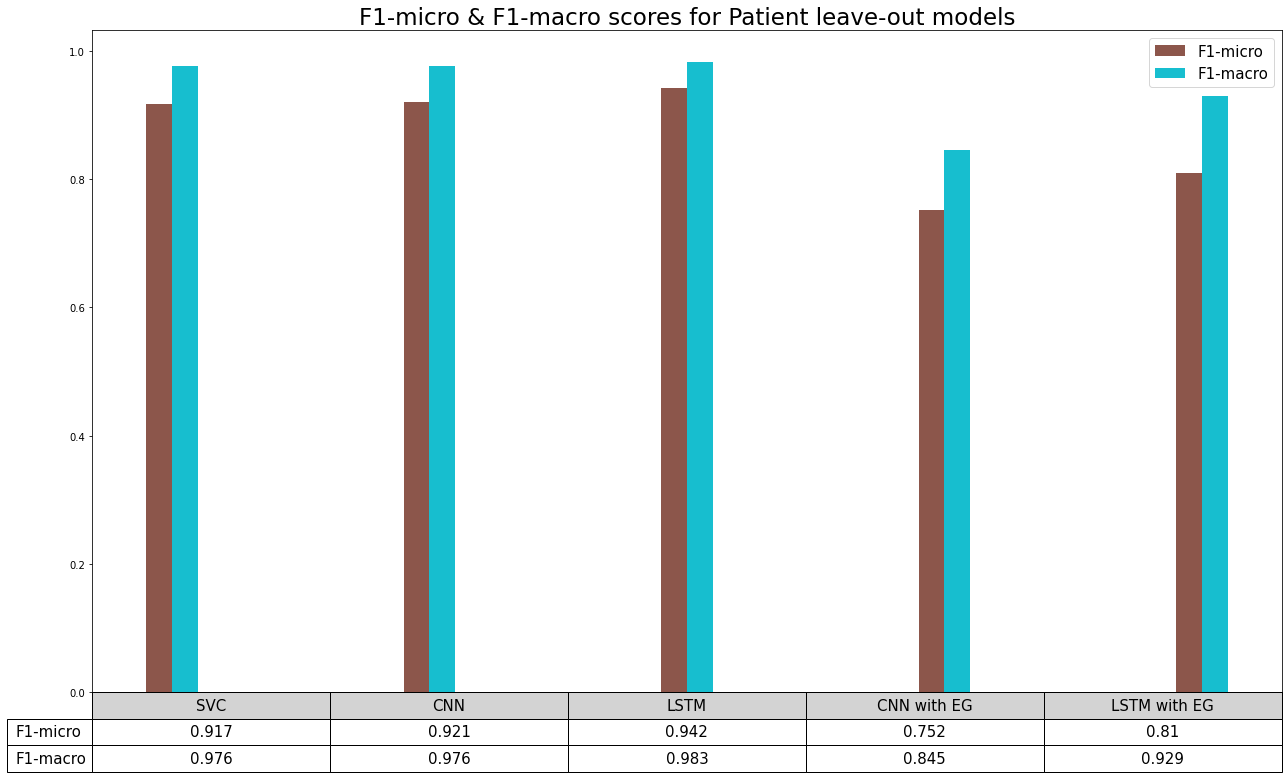

In [78]:
X = np.arange(len(r_name))
fig = plt.figure(figsize=(18, 11))
# ax = fig.add_axes([0,0,1,1])
plt.bar(X , r[0], color = 'tab:brown', width = 0.1)
plt.bar(X + 0.10, r[1], color = 'tab:cyan', width = 0.1)

plt.legend(rows, prop={"size":15})
plt.xticks([])

# Add a table at the bottom of the axes
the_tabel = plt.table(cellText=r,
                      rowLabels=rows,
                      cellLoc='center',
                      # rowColours=['tab:brown', 'tab:cyan', 'tab:orange', 'tab:red'],
                      colLabels=r_name,
                      colColours=["lightgrey" for i in range(5)],
                      loc='bottom')                   
the_tabel.auto_set_font_size(False)
the_tabel.set_fontsize(15)
the_tabel.scale(1,2)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.title("F1-micro & F1-macro scores for Patient leave-out models", fontsize=23)
plt.tight_layout()
# plt.savefig("./images/pl_f1mm", dpi=300)
plt.show()


In [41]:
svc_ph_r = get_results(foldername="svc_ph", tname="ph")
cnn_ph_r = get_results(foldername="cnn_ph", tname="ph")
lstm_ph_r = get_results(foldername="lstm_ph", tname="ph")
cnn_ph_eg_r = get_results(foldername="cnn_ph_eg", tname="ph")
lstm_ph_eg_r = get_results(foldername="lstm_ph_eg", tname="ph")

r = np.array([svc_ph_r.mean(axis=0), cnn_ph_r.mean(axis=0), lstm_ph_r.mean(axis=0), cnn_ph_eg_r.mean(axis=0), lstm_ph_eg_r.mean(axis=0)]).T
# r[3:] = (r[3]+r[4])/2
r = r[-2:]
r = np.around(r.astype(np.float32), 3)
r_name = ["SVC","CNN", "LSTM", "CNN with EG", "LSTM with EG"]
rows = ["F1-micro", "F1-macro"]

In [42]:
f1mi_error = [svc_ph_r.T[3].std(),cnn_ph_r.T[3].std(), lstm_ph_r.T[3].std(), cnn_ph_eg_r.T[3].std(), lstm_ph_eg_r.T[3].std()]
f1ma_error = [svc_ph_r.T[4].std(),cnn_ph_r.T[4].std(), lstm_ph_r.T[4].std(), cnn_ph_eg_r.T[4].std(), lstm_ph_eg_r.T[4].std()]


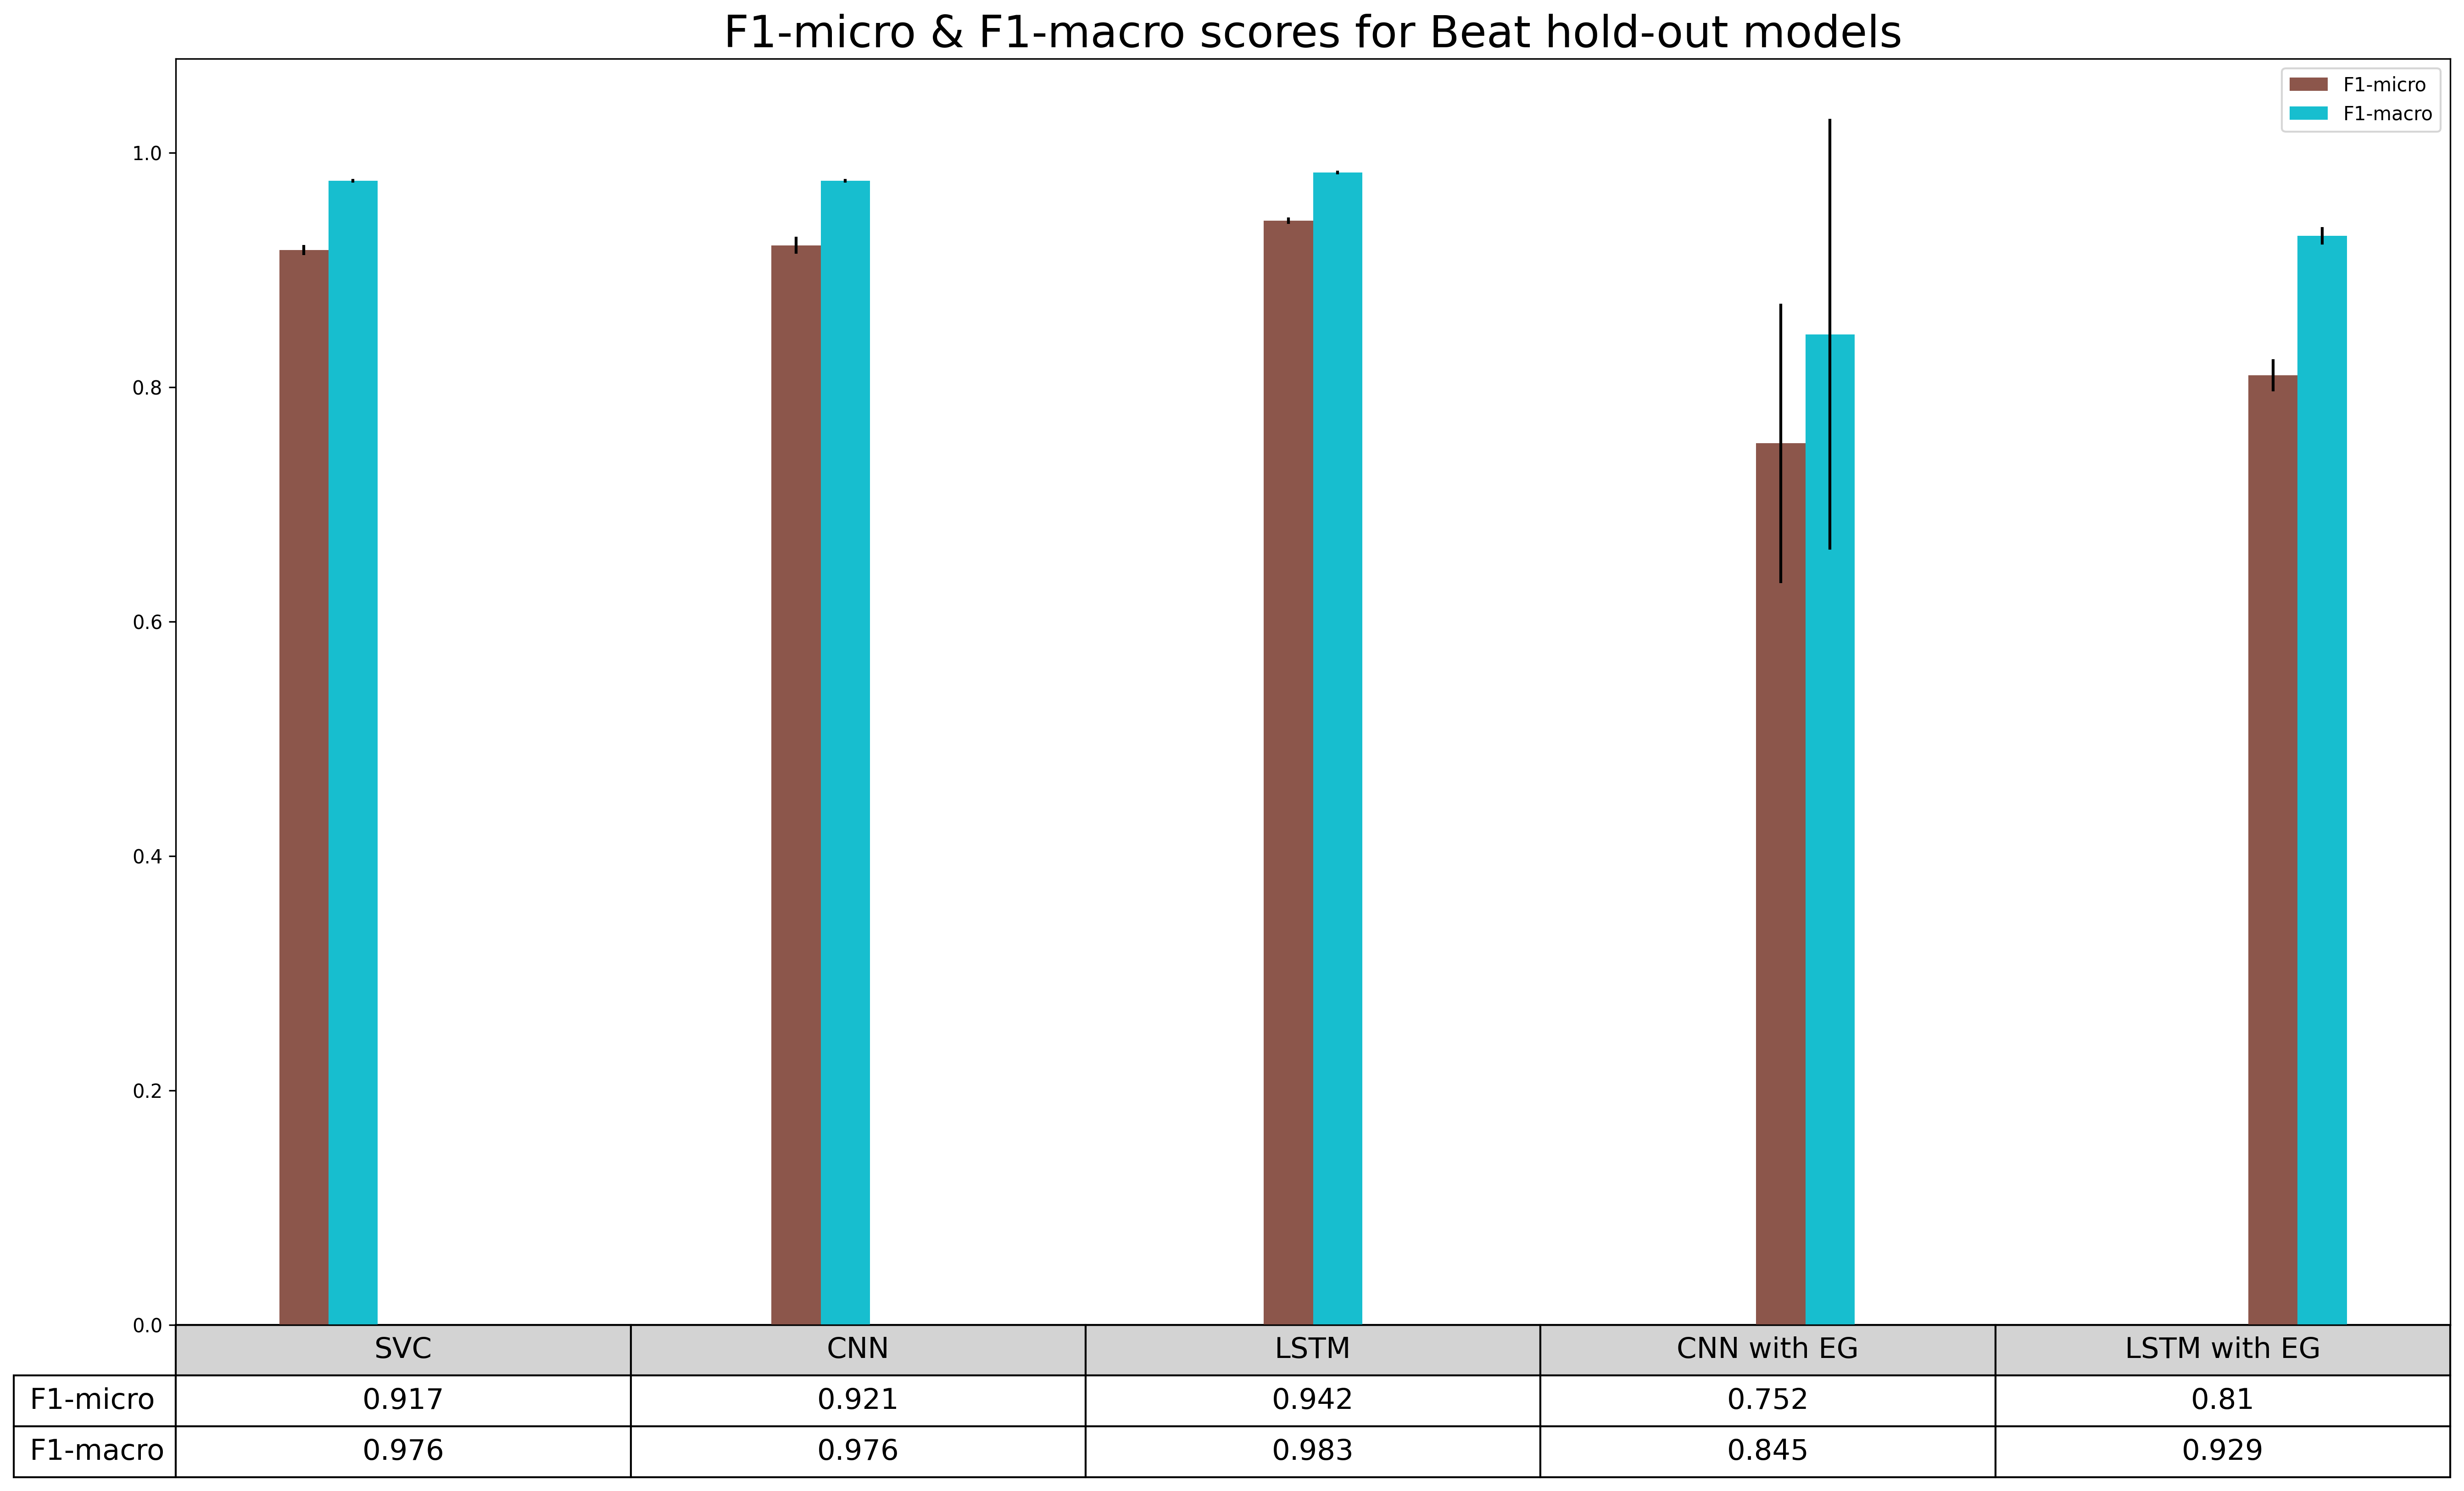

In [79]:
X = np.arange(len(r_name))
fig = plt.figure(figsize=(18,11), dpi=300)
# ax = fig.add_axes([0,0,1,1])

plt.bar(X , r[0], yerr=f1mi_error, color = 'tab:brown', width = 0.1)
plt.bar(X + 0.10, r[1], yerr=f1ma_error, color = 'tab:cyan', width = 0.1)

plt.legend(rows)
plt.xticks([])

# Add a table at the bottom of the axes
the_tabel = plt.table(cellText=r,
                      rowLabels=rows,
                      cellLoc='center',
                      # rowColours=['tab:blue', 'tab:green', 'tab:orange', 'tab:red'],
                      colLabels=r_name,
                      colColours=["lightgrey" for i in range(5)],
                      loc='bottom')                   
the_tabel.auto_set_font_size(False)
the_tabel.set_fontsize(15)
the_tabel.scale(1,2)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.title("F1-micro & F1-macro scores for Beat hold-out models", fontsize=23)
plt.tight_layout()
# plt.savefig("./images/ph_f1mm", dpi=300)
plt.show()
